<a href="https://colab.research.google.com/github/waynchi/SC-Net/blob/master/SC_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
!pip install mnist
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [136]:
import tensorflow as tf
tf.test.is_gpu_available()


True

# What about a GAN + Self correcting U-Net ? That would make for a cool architecture
# Following CGAN -> adding a 1-hot vector encoding of the label to the training data
# Simulated Annealing?
# Generator -> VAE -> Discriminator?
# What about feeding in a dicriminator's confidence level as a temperature during the autoregressive? Inverse confidence?
# What about a 3 dimensional GAN?

# Umut Notes
- Add a stop condition to the softmax
- 2 steps process (pick note and then choose how much through binary cross entropy)

In [137]:
import mnist
import scipy.misc
from PIL import Image
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy

def create_image(image, name, image_shape=(28, 28)):
    img_arr = deepcopy(image.reshape(image_shape)).astype(np.uint8)
    # print("img shape: {}. img sum: {}".format(img_arr.shape, img_arr.sum()))
    # print(img_arr)
    img_arr[img_arr > 0] = 255
    # pprint(img_arr)
    # print("img shape: {}. img sum: {}".format(img_arr.shape, img_arr.sum()))
    img = Image.fromarray(img_arr.astype(np.uint8), 'L')
    img.save(name)
    return img

images = mnist.train_images()
num_samples = 10
np.random.shuffle(images)
images = images[:num_samples, :, :]
# For black and white
images[images > 0] = 1

# For grayscale
# images = images / 255.0
# images = images.reshape(images.shape[0], -1)
pprint(images)
print(images.shape)

labels = mnist.train_labels()
n_labels = np.max(labels) + 1
labels = np.eye(n_labels)[labels]
print(labels.shape)

create_image(images[0], 'my.png')
print(labels[0])

# images = images[:1000, :, :]
# print(images[0].shape)
# pprint(images[0])
# img = Image.fromarray(images[0], 'L')
# img.save('my.png')
# img.show()

image_shape = np.expand_dims(images[0], axis=-1).shape 
# print(image_shape)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [0]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.utils import plot_model
from keras import backend as K
from tensorflow.python.ops import math_ops

def built_in_softmax_kl_loss(target, output):
    target = K.flatten(target)
    output = K.flatten(output)
    
    target = target / K.sum(target)
    output = K.softmax(output)
    return keras.losses.kullback_leibler_divergence(target, output)

keras.losses.built_in_softmax_kl_loss = built_in_softmax_kl_loss
 
def unet_model(input_size=(28, 28, 1), n_filters_start=32, growth_factor=2,
               upconv=False):
    droprate=0.5
    n_filters = n_filters_start
    inputs = Input(input_size)
    conv_first = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
    conv_first = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv_first)
    pool_first = MaxPooling2D(pool_size=(2, 2))(conv_first)

    prev_pool = pool_first
    hidden_layers = []
    for _ in range(1):
        n_filters *= growth_factor
        pool = BatchNormalization()(prev_pool)
        conv = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool)
        conv = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv)
        pool = MaxPooling2D(pool_size=(2, 2))(conv)
        pool = Dropout(droprate)(pool)
        prev_pool = pool
        hidden_layers.append(conv)
 
    n_filters *= growth_factor
    conv_mid = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(prev_pool)
    conv_mid = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv_mid)
 
    n_filters //= growth_factor
    if upconv:
        up_first = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv_mid), hidden_layers[-1]])
    else:
        up_first = concatenate([UpSampling2D(size=(2, 2))(conv_mid), hidden_layers[-1]])
    up_first = BatchNormalization()(up_first)
    conv_mid_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up_first)
    conv_mid_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv_mid_2)
    conv_mid_2 = Dropout(droprate)(conv_mid_2)

    prev_conv = conv_mid_2
    for i in range(0):
        n_filters //= growth_factor
        if upconv:
            up = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(prev_conv), hidden_layers[-i-2]])
        else:
            up = concatenate([UpSampling2D(size=(2, 2))(prev_conv), hidden_layers[-i-2]])
        up = BatchNormalization()(up)
        conv = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up)
        conv = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv)
        conv = Dropout(droprate)(conv)
        prev_conv = conv
 
    n_filters //= growth_factor
    if upconv:
        up_last = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv_mid_2), conv_first])
    else:
        up_last = concatenate([UpSampling2D(size=(2, 2))(conv_mid_2), conv_first])
    conv_last = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up_last)
    conv_last = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv_last)
 
    conv_out = Conv2D(1, 1, activation='linear')(conv_last)
    output = Flatten()(conv_out)

    flatten = Flatten()(conv_last)
    dense = Dense(1, activation='linear')(flatten)

    output = concatenate([output, dense])
 
    model = Model(inputs=inputs, outputs=output)
    # model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(), loss=built_in_softmax_kl_loss)
    model.summary()
    return model

In [153]:
model = unet_model(input_size=image_shape)

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_254 (Conv2D)             (None, 28, 28, 32)   320         input_24[0][0]                   
__________________________________________________________________________________________________
conv2d_255 (Conv2D)             (None, 28, 28, 32)   9248        conv2d_254[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_47 (MaxPooling2D) (None, 14, 14, 32)   0           conv2d_255[0][0]                 
___________________________________________________________________________________________

In [0]:
# discriminator_model = discriminator(input_size=image_shape)

In [0]:
from copy import deepcopy
import math
import itertools
def mask_image(image):
    image = deepcopy(image)
    sampling_percentage = np.random.uniform(0, 100)
    non_zero = np.nonzero(image)
    mask1 = np.full(len(non_zero[0]), False)
    mask1[:math.floor(len(non_zero[0]) * (sampling_percentage/100))] = True
    np.random.shuffle(mask1)
    # pprint(mask1)
    r1 = list(itertools.compress(non_zero[0], mask1))
    c1 = list(itertools.compress(non_zero[1], mask1))
    output_image = deepcopy(image)
    output_image[r1,c1] = 0
    return output_image

def mask_image_with_noise(image):
    image = deepcopy(image)
    sampling_percentage_mask = np.random.uniform(0, 100)
    sampling_percentage_noise = np.random.uniform(0, 20)
    non_zero = np.nonzero(image)
    zeroes = np.nonzero(image == 0)
    mask = np.full(len(non_zero[0]), False)
    noise = np.full(len(zeroes[0]), False) 
    amount_to_mask = math.floor(len(non_zero[0]) * (sampling_percentage_mask/100))
    mask[:amount_to_mask] = True
    amount_to_mask_2 = math.floor(len(zeroes[0]) * (sampling_percentage_noise/100))
    noise[:amount_to_mask_2] = True
    np.random.shuffle(mask)
    np.random.shuffle(noise)
    # pprint(mask1)
    output_image = deepcopy(image)
    r1 = list(itertools.compress(non_zero[0], mask))
    c1 = list(itertools.compress(non_zero[1], mask))
    r2 = list(itertools.compress(zeroes[0], noise))
    c2 = list(itertools.compress(zeroes[1], noise))
    output_image[r1,c1] = 0
    output_image[r2,c2] = 1
    return output_image

def mask_image_with_noise_grayscale(image):
    image = deepcopy(image)
    sampling_percentage_mask = np.random.uniform(0, 100)
    sampling_percentage_noise = np.random.uniform(0, 20)
    non_zero = np.nonzero(image)
    zeroes = np.nonzero(image == 0)
    mask = np.full(len(non_zero[0]), False)
    noise = np.full(len(zeroes[0]), False) 
    amount_to_mask = math.floor(len(non_zero[0]) * (sampling_percentage_mask/100))
    mask[:amount_to_mask] = True
    amount_to_mask_2 = math.floor(len(zeroes[0]) * (sampling_percentage_noise/100))
    noise[:amount_to_mask_2] = True
    np.random.shuffle(mask)
    np.random.shuffle(noise)
    # pprint(mask1)
    output_image = deepcopy(image)
    r1 = list(itertools.compress(non_zero[0], mask))
    c1 = list(itertools.compress(non_zero[1], mask))
    r2 = list(itertools.compress(zeroes[0], noise))
    c2 = list(itertools.compress(zeroes[1], noise))
    output_image[r1,c1] = -1.0
    output_image[r2,c2] = 1.0
    return output_image

class ImageGenerator(keras.utils.Sequence):
    def __init__(self, sample_list, image_shape, batch_size, samples_per_data_item, seed=None):
        print("sample_list: {}".format(len(sample_list)))
        self.sample_list = sample_list
        self.image_shape = image_shape
        self.batch_size = batch_size
        self.samples_per_data_item = samples_per_data_item
        # self.training_input = []
        # self.training_target = []
        # self.training_original = []
        self.sample_index = 0
        self.seed = seed
        # if self.seed is not None:
        #     np.random.seed(self.seed)

    def generate_training_pairs(self):
        '''
        Generates Training Pairs till @training_input / @training_target have @batch_size files.
        '''
        training_input = []
        training_original = []
        training_target = []
        while len(training_input) < self.batch_size:
            original_image = deepcopy(self.sample_list[self.sample_index])
            original_image = original_image.reshape(self.image_shape)
            original_image[original_image > 0] = 1
            self.sample_index = (self.sample_index + 1) % len(self.sample_list)
            # print("sample_list length: {}. sample_index: {}".format(
            #     len(self.sample_list), self.sample_index))
            try:
                # augment by adding and removing random values in the array

                # Add random values
                for _ in range(self.samples_per_data_item):
                    input_image = mask_image_with_noise(original_image)

                    # xor_target = original_image
                    xor_target = np.logical_xor(input_image, original_image)
                    input_image = input_image.astype(np.float32)
                    xor_target = xor_target.astype(np.float32)
                    xor_target = xor_target.flatten()
                    xor_target = np.append(xor_target, 0.0)
                    original_image = original_image.astype(np.float32)
                    training_input.append(deepcopy(input_image))
                    training_original.append(deepcopy(original_image))
                    training_target.append(deepcopy(xor_target))

                # Add original
                training_input.append(deepcopy(input_image))
                training_original.append(deepcopy(original_image))
                training_target.append(deepcopy(xor_target))
                
            except Exception as e:
                print('Error generating input and target pair')
                traceback.print_exc()
        return np.asarray(training_input), np.asarray(training_target), np.asarray(training_original)

    def save_image(self, img_arr, img_name):
        img_arr = img_arr.reshape(self.image_shape)
        print(img_name)
        print("img shape: {}. img sum: {}".format(img_arr.shape, img_arr.sum()))
        img_arr = img_arr[:, :, 0]
        print("img shape: {}. img sum: {}".format(img_arr.shape, img_arr.sum()))
        #pprint(img_arr)
        img_arr[img_arr != 0] = 255
        #pprint(img_arr)
        print("img shape: {}. img sum: {}".format(img_arr.shape, img_arr.sum()))
        img = Image.fromarray(img_arr.astype(np.uint8), 'L')
        img.save(img_name)

    def get_random_training_pair(self):
        import random
        training_input, training_target, training_original = self.generate_training_pairs()
        print("training_input shape: {}".format(training_input.shape))
        index = random.randrange(0, len(training_input))
        self.save_image(deepcopy(training_input[index]), 'training_input.png')
        training_image = training_target[index][:np.prod(self.image_shape)]
        print(training_target[index][-1])
        self.save_image(deepcopy(training_image), 'training_target.png')
        self.save_image(deepcopy(training_original[index]), 'training_original.png')

    def generate_validation_samples(self):
        old_batch_size = self.batch_size
        self.batch_size = len(self.sample_list) * self.samples_per_data_item
        training_input, training_target, training_original = self.generate_training_pairs()
        # training_input = np.asarray(self.training_input[:self.batch_size])
        # training_target = np.asarray(self.training_target[:self.batch_size])
        self.batch_size = old_batch_size
        return training_input, training_target

    def __getitem__(self, index):
        '''Generates 1 batch of data'''
        training_input, training_target, training_original = self.generate_training_pairs()
        # training_input = np.asarray(self.training_input[:self.batch_size])
        # training_target = np.asarray(self.training_target[:self.batch_size])
        # self.training_input = self.training_input[self.batch_size:]
        # self.training_target = self.training_target[self.batch_size:]
        # print("training input sum: {}. target sum: {}".format(training_input.sum(), training_target.sum()))
        return np.asarray(training_input), np.asarray(training_target)

    def __len__(self):
        '''Number of batches / epoch'''
        # print("sample_list: {}. samples_per_data_item: {}, batch size: {}".
        #       format(len(self.sample_list), self.samples_per_data_item,
        #              self.batch_size))
        samples_to_generate = int(
            (len(self.sample_list) * self.samples_per_data_item) /
            self.batch_size)
        # print("samples to generate: {}".format(samples_to_generate))
        return samples_to_generate
    
    #def on_epoch_end(self):
    #    if self.seed is not None:
    #        np.random.seed(self.seed)


In [0]:
# Config
batch_size = 128
samples_per_data_item = 1 # add oen to this for the number of TRUTH samples
split = 0.8

In [162]:

training_samples = images[:int(len(images) * split)]
validation_samples = images[int(len(images) * split):]

print("training samples: {}. validation samples: {}".format(len(training_samples), len(validation_samples)))

steps_per_epoch = int(len(training_samples) * samples_per_data_item / batch_size)

# pprint(training_samples[0])

training_generator = ImageGenerator(
    sample_list=training_samples,
    image_shape=image_shape,
    batch_size=batch_size,
    samples_per_data_item=samples_per_data_item)

validation_generator = ImageGenerator(
    sample_list=validation_samples,
    image_shape=image_shape,
    batch_size=batch_size,
    samples_per_data_item=samples_per_data_item)

validation_data = validation_generator.generate_validation_samples()

# print("validation data input and target shape: {}".format(validation_data[0].shape))
training_generator.get_random_training_pair()




training samples: 8000. validation samples: 2000
sample_list: 8000
sample_list: 2000
training_input shape: (128, 28, 28, 1)
training_input.png
img shape: (28, 28, 1). img sum: 101.0
img shape: (28, 28). img sum: 101.0
img shape: (28, 28). img sum: 25755.0
0.0
training_target.png
img shape: (28, 28, 1). img sum: 250.0
img shape: (28, 28). img sum: 250.0
img shape: (28, 28). img sum: 63750.0
training_original.png
img shape: (28, 28, 1). img sum: 175.0
img shape: (28, 28). img sum: 175.0
img shape: (28, 28). img sum: 44625.0


In [0]:
model_location = F'/content/drive/My Drive/sc-model.hdf5'


In [145]:
import os

model = unet_model(input_size=(28, 28, 1))
# model = keras.models.load_model(model_location)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=model_location,
    monitor='val_loss',
    save_weights_only=False,
    verbose=1,
    mode='min',
    save_best_only=True)

tensorboard_callback = keras.callbacks.TensorBoard(log_dir='./logs', update_freq='epoch')

if True:
    history = model.fit(
        training_generator,
        validation_data=validation_data,
        verbose=1,
        shuffle=True,
        steps_per_epoch=steps_per_epoch,
        epochs=20,
        callbacks=[model_checkpoint_callback, tensorboard_callback])
    #epochs=cfg.epochs,
    #callbacks=callbacks)
# model.save("sc-model.hdf5")

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_232 (Conv2D)             (None, 28, 28, 32)   320         input_22[0][0]                   
__________________________________________________________________________________________________
conv2d_233 (Conv2D)             (None, 28, 28, 32)   9248        conv2d_232[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_43 (MaxPooling2D) (None, 14, 14, 32)   0           conv2d_233[0][0]                 
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135485). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


62/62 [==============================] - 4s 68ms/step - loss: 1.1069 - val_loss: 1.0712

Epoch 00001: val_loss improved from inf to 1.07118, saving model to /content/drive/My Drive/sc-model.hdf5
Epoch 2/20
62/62 [==============================] - 3s 51ms/step - loss: 0.6250 - val_loss: 0.7150

Epoch 00002: val_loss improved from 1.07118 to 0.71504, saving model to /content/drive/My Drive/sc-model.hdf5
Epoch 3/20
62/62 [==============================] - 3s 52ms/step - loss: 0.5390 - val_loss: 0.6029

Epoch 00003: val_loss improved from 0.71504 to 0.60287, saving model to /content/drive/My Drive/sc-model.hdf5
Epoch 4/20
62/62 [==============================] - 3s 52ms/step - loss: 0.5180 - val_loss: 0.5433

Epoch 00004: val_loss improved from 0.60287 to 0.54334, saving model to /content/drive/My Drive/sc-model.hdf5
Epoch 5/20
62/62 [==============================] - 3s 51ms/step - loss: 0.5052 - val_loss: 0.5129

Epoch 00005: val_loss improved from 0.54334 to 0.51295, saving model to /co

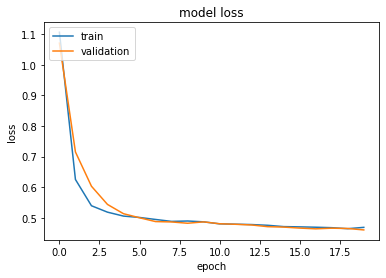

In [146]:
# "Loss"
if True:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# Inference

In [0]:
import os
import shutil
import time

def inference(model, input_image, directory, iterations, temp_start=2, temp_end=0.5):
    create_image(input_image, "{}/input.png".format(directory))

    temperatures = np.linspace(temp_end, temp_start, num=iterations)[::-1]
    # pprint(temperatures)
    
    working_image = deepcopy(input_image)
    working_images = []
    num_added = 0
    num_removed = 0
    for i in range(iterations):
        temp = temperatures[i]
        predictions = model.predict(working_image)
        predictions = predictions.flatten()
        predictions = np.exp(predictions / temp)
        predictions = predictions / np.sum(predictions)
        # print(predictions)
        indices = np.arange(predictions.shape[0])
        index = np.random.choice(indices, p=predictions)
        working_image = working_image.flatten()
        if working_image[index] == 1:
            num_removed += 1
            working_image[index] = 0
        elif working_image[index] == 0:
            num_added += 1
            working_image[index] = 1
        else:
            print(working_image[index])
        working_image = np.reshape(working_image, [1, *image_shape])
        if i % 50 == 0:
            create_image(working_image, os.path.join(directory, "working_{}.png".format(i)))

    print(working_image.shape)
    print("num added: {}. num removed: {}".format(num_added, num_removed))
    img = create_image(working_image, os.path.join(directory, "final.png"))
    return img, deepcopy(working_image)



In [149]:
generated_images = []

# model = keras.models.load_model(model_location)


def generate_noise():
    input_image = np.full((28, 28), 0)
    # input_image = np.random.rand(28, 28)
    # input_image[input_image >= 0.5] = 1
    # input_image[input_image < 0.5] = 0
    input_image = input_image.astype(np.float32)
    input_image = np.expand_dims(input_image, 0)
    input_image = np.expand_dims(input_image, -1)
    return input_image

sample_sqrt = 2
for i in range(sample_sqrt**2):
    directory = "images_{}".format(i)
    os.makedirs(directory, exist_ok=True)
    input_image = generate_noise()

    img, _ = inference(model, input_image, directory, 200, temp_start=1, temp_end=1)
    generated_images.append(img)
    
final_im = Image.new('RGB', (28 * sample_sqrt, 28 * sample_sqrt))

y_offset = 0
for i in range(sample_sqrt):
    x_offset = 0
    new_im = Image.new('RGB', (28 * sample_sqrt, 28))
    for j in range(sample_sqrt):
        im = generated_images[(i * sample_sqrt) + j]
        new_im.paste(im, (x_offset, 0))
        x_offset += 28
    final_im.paste(new_im, (0, y_offset))
    y_offset += 28
    
final_im.save('final.png')

(1, 28, 28, 1)
num added: 146. num removed: 54
(1, 28, 28, 1)
num added: 144. num removed: 56
(1, 28, 28, 1)
num added: 162. num removed: 38
(1, 28, 28, 1)
num added: 151. num removed: 49


## Train Discriminator

In [0]:
iterations = 500
 
generated_samples = []
for i in range(int(len(training_samples) / 2)):
    directory = "discriminator"
    os.makedirs(directory, exist_ok=True)
    input_image = generate_noise()

    _, generated = inference(model, input_image, directory, iterations, temp_start=1, temp_end=1)
    generated_samples.append(generated)

print(len(generated_samples))
original_gen_samples = deepcopy(generated_samples)
generated_samples = np.asarray(generated_samples)
print(generated_samples.shape)

In [0]:
random_samples = np.random.rand(int(len(training_samples) / 2), *image_shape)
random_samples[random_samples >= 0.5] = 1
random_samples[random_samples < 0.5] = 0

generated_samples = generated_samples.reshape(-1, *image_shape)
images = training_samples
images = np.expand_dims(images, axis=-1)

discriminator_train_x = np.concatenate((generated_samples, random_samples, images), axis=0)
print(generated_samples.shape)
print(random_samples.shape)
print(images.shape)
discriminator_train_y = np.concatenate((np.full((generated_samples.shape[0], 1), 0), 
                                        np.full((random_samples.shape[0], 1), 0),
                                        np.full((images.shape[0], 1), 1)), 
                                        axis=0)

print(discriminator_train_x.shape)
print(discriminator_train_y.shape)


p = np.random.permutation(len(discriminator_train_x))
discriminator_train_x, discriminator_train_y = discriminator_train_x[p], discriminator_train_y[p]
print(discriminator_train_x.shape)
print(discriminator_train_y.shape)

In [0]:
from keras.layers import Flatten, Dense, Reshape

def discriminator(input_size=(28, 28, 1), n_filters_start=16, growth_factor=2, num_layers=1):
    inputs = Input(input_size)
    droprate = 0.5
    n_filters = n_filters_start
    prev_layer = inputs
    for _ in range(num_layers):
        batch_norm = BatchNormalization()(prev_layer)
        conv = Conv2D(n_filters, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(batch_norm)
        drop_layer = Dropout(droprate)(conv)
        prev_layer = drop_layer
        n_filters *= growth_factor

    flatten = Flatten()(prev_layer)
    # reshape_layer = Reshape((-1, 512))(prev_layer)
    validity = Dense(1, activation='sigmoid')(flatten)

    model = Model(inputs=inputs, outputs=validity)
    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [0]:
discriminator_model = discriminator(input_size=image_shape)
model_location = F'/content/drive/My Drive/sc-discrim-model.hdf5'

# model = keras.models.load_model(model_location)

discrim_batch_size = 64

steps_per_epoch = int(len(discriminator_train_x) * split / discrim_batch_size)  
validation_steps = int(len(discriminator_train_x) * (1 - split) / discrim_batch_size)  

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=model_location,
    monitor='val_loss',
    save_weights_only=False,
    verbose=1,
    mode='min',
    save_best_only=True)

tensorboard_callback = keras.callbacks.TensorBoard(log_dir='./logs', update_freq='epoch')

if True:
    discrim_history = discriminator_model.fit(
        x=discriminator_train_x,
        y=discriminator_train_y,
        batch_size=discrim_batch_size,
        validation_split=split,
        verbose=1,
        shuffle=True,
        epochs=100,
        callbacks=[model_checkpoint_callback, tensorboard_callback])
    #epochs=cfg.epochs,
    #callbacks=callbacks)
# model.save("sc-model.hdf5")
if True:
    plt.plot(discrim_history.history['loss'])
    plt.plot(discrim_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [0]:
def inference_with_discriminator(model, discrim_model, input_image, directory, iterations, temp_low=0.5, temp_high=2):
    create_image(input_image, "{}/input.png".format(directory))

    # pprint(temperatures)
    
    working_image = deepcopy(input_image)
    consecutive = 0
    for i in range(iterations):
        discrim_predict = discrim_model.predict(working_image)[0]
        if discrim_predict >= 0.95:
            consecutive += 1
            if consecutive >= 100:
                break
        else:
            consecutive = 0

        temp = temp_low + ((temp_high - temp_low) * (1 - discrim_predict))
        
        print("temp: {}".format(temp))
        predictions = model.predict(working_image)
        predictions = predictions.flatten()
        predictions = np.exp(predictions / temp)
        predictions = predictions / np.sum(predictions)
        # print(predictions)
        indices = np.arange(predictions.shape[0])
        index = np.random.choice(indices, p=predictions)
        working_image = working_image.flatten()
        if working_image[index] == 1:
            working_image[index] = 0
        elif working_image[index] == 0:
            working_image[index] = 1
        else:
            print(working_image[index])
        working_image = np.reshape(working_image, [1, *image_shape])
        if i % 100 == 0:
            create_image(working_image, os.path.join(directory, "working_{}.png".format(i)))

    print(working_image.shape)
    img = create_image(working_image, os.path.join(directory, "final.png"))
    return img, deepcopy(working_image)


In [0]:
generated_images = []

sample_sqrt = 1
for i in range(sample_sqrt**2):
    directory = "images_discrim_{}".format(i)
    os.makedirs(directory, exist_ok=True)
    # input_image = images[0]
    # input_image = np.expand_dims(input_image, 0)

 
    img, _ = inference_with_discriminator(model, discriminator_model, input_image, directory, 10000)
    generated_images.append(img)
    
final_im = Image.new('RGB', (28 * sample_sqrt, 28 * sample_sqrt))

y_offset = 0
for i in range(sample_sqrt):
    x_offset = 0
    new_im = Image.new('RGB', (28 * sample_sqrt, 28))
    for j in range(sample_sqrt):
        im = generated_images[(i * sample_sqrt) + j]
        new_im.paste(im, (x_offset, 0))
        x_offset += 28
    final_im.paste(new_im, (0, y_offset))
    y_offset += 28
    
final_im.save('final_with_discrim.png')